## Introduction

The purpose of this example is to demonstrate the API's ability to work with a variety of machine learning libraries.
Here we use scikit learn's `LogisticRegression` class to implement a logistic regression model for image classification of the MNIST dataset.
This is inspired and partially taken from thie example of scikit's website:<br>
&emsp;&emsp;https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html


## Downloading the Dataset

The MNIST dataset consists of 70000 28x28 grayscale images of handwritten numbers.
Each image is stored as a column vector, resulting in a (70000,784) shape for the entire dataset.

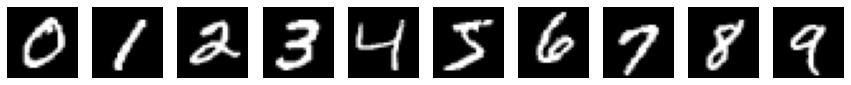

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X/X.max()

# Find examples of each class
ref_inds = []
for i in range(10):
    ref_inds.append(np.where(np.int64(y) == i)[0][0])
    
ref_imgs = X[ref_inds]

# Plot examples
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(ref_imgs[i].reshape(28, 28), 'gray')
    plt.axis('off')
    

## Fitting the Model

We will fit the regression with L2 penalty on a subset of the dataset using a higher tolerance to shorten the time needed for convergence. 

The coefficients of the fit model can be used to visualize the deicison boundaries for each class.
We use a relatively high regulation strength when fitting the model in order to reduce the complexity, making the shape of the coefficients easier to visualize.

Test score with L2 penalty: 0.8758
Example run in 2.449 s


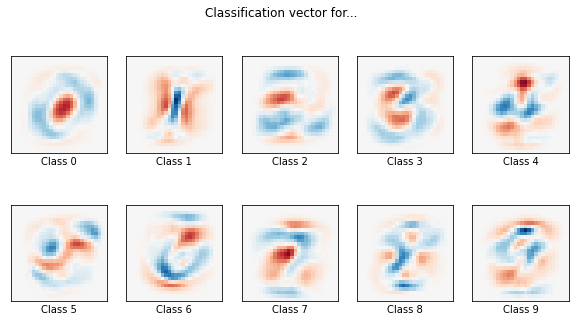

In [2]:
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

t0 = time.time()

# Split data into test and train sets
train_samples = 20000

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

# Define model, lower C value gives higher regulation
clf = LogisticRegression(
    C=0.001, penalty='l2', solver='saga', tol=0.1
)

# Fit model
clf.fit(X_train, y_train)

# Score model
score = clf.score(X_test, y_test)
print("Test score with L2 penalty: %.4f" % score)

# Visualize coefficients
coef = clf.coef_.copy()
max_val = np.abs(coef).max()

plt.figure(figsize=(10, 5))
for i in range(10):
    p = plt.subplot(2, 5, i + 1)
    p.imshow(coef[i].reshape(28, 28), cmap=plt.cm.RdBu,
             vmin=-max_val, vmax=max_val)
    p.set_xticks(())
    p.set_yticks(())
    p.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')

run_time = time.time() - t0
print('Example run in %.3f s' % run_time)
plt.show()

## The "Application"

We can use the `xaitk-saliency` high-level API to generate saliency maps that compare to the visualization above.

Our "application" will accept a set of images, a blackbox image classifier, and a saliency generator and will generate saliency maps for each image provided.
It will then combine the heatmaps of each corresponding class and plot them.
This should give us a view of the decision boundaries for each class similar to the one above.

In [3]:
from smqtk_classifier import ClassifyImage
from xaitk_saliency import GenerateImageClassifierBlackboxSaliency
from functools import reduce
from math import ceil

def app(
    images: np.ndarray,
    image_classifier: ClassifyImage,
    saliency_generator: GenerateImageClassifierBlackboxSaliency
):
    num_imgs = images.shape[0]
    
    # Generate saliency maps
    sal_maps = []
    for i in range(num_imgs):    
        ref_image = images[i].reshape(28, 28)
        sal_maps.append(saliency_generator(ref_image, image_classifier))
    
    # Combine respective class maps
    combined_maps = reduce(np.add, sal_maps)
    
    # Plot combined maps
    plt.figure(figsize=(10, 5))
    for i in range(num_imgs):
        max_val = combined_maps[i].max()
        plt.subplot(2, ceil(num_imgs/2), i + 1)
        plt.imshow(combined_maps[i], cmap=plt.cm.RdBu, vmin=-max_val, vmax=max_val)
        plt.axis('off')

## Blackbox Classifier

Here we wrap our logistic regression in a `ClassifyImage` class to comply with the API's interface.

In [4]:
class MNISTClassifier (ClassifyImage):
    def get_labels(self):
        return [i for i in range(10)]
    
    def classify_images(self, image_iter):
        
        # Convert image set back to column vector form
        images = np.array([]).reshape(0, 28*28)
        for img in image_iter:
            images = np.vstack((images, img.reshape(1, -1)))
        
        return clf.decision_function(images)
            
    # Required for implementation
    def get_config(self):
        return {}
    
image_classifier = MNISTClassifier()

## Heatmap Generation

We create a `SlidingWindowStack` object to carry out our image perturbation and heatmap generation.

In [5]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.rise import RISEStack
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

gen_slidingWindow = SlidingWindowStack(
    window_size=(2, 2),
    stride=(1, 1),
    threads=4
)

## Calling the Application

Finally, we call the application using the images we plotted after loading the dataset consisting of one example from each class.

The heatmaps created with this method, even with a small set of images, are comparable to those created using the coefficients of our regression.
However, these were created directly from the behavior of the classification model and without knowing any its intrinsic properties.

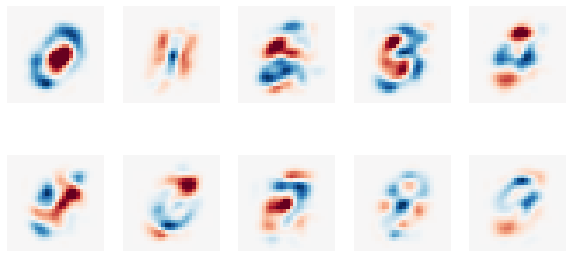

In [7]:
app(
    ref_imgs,
    image_classifier,
    gen_slidingWindow
)